#### Metrics Documentation (Classification and Regression)

#https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

In [1]:
import os 
import json
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_auc_score, mean_squared_error

In [2]:
import os
# Office
#os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction')
#data = pd.read_csv('LoanTrain.csv')

# Personal
os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction')
data = pd.read_csv('Loan Prediction Train.csv')

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

class PreProcessing(BaseEstimator, TransformerMixin):


    def __init__(self):
        pass

    def transform(self, df):

        pred_var = ['Gender','Married','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
        
        df = df[pred_var].reset_index(drop=True)
        
        #df['Dependents'] = df['Dependents'].fillna(0)
        df['Self_Employed'] = df['Self_Employed'].fillna('No')
        df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(self.term_mean_)
        df['Credit_History'] = df['Credit_History'].fillna(1)
        df['Married'] = df['Married'].fillna('No')
        df['Gender'] = df['Gender'].fillna('Male')
        df['LoanAmount'] = df['LoanAmount'].fillna(self.amt_mean_)
        
        #loading a MINMAX Scaler from a file called minmax_pickle.pkl
        MinMaxpickle_in = open("C:\\Users\\prudi\Desktop\\Data Sets\\Loan Prediction\\minmax_pickle.pkl","rb")
        MinmaxScaler_dict = pickle.load(MinMaxpickle_in)
        df['ApplicantIncome']=pd.DataFrame(MinmaxScaler_dict['ApplicantIncome'].fit_transform(df[['ApplicantIncome']]))
        
        #loading a One Hot Encoder Scaler from a file called binarizer_pickle.pkl
        Onehotpickle_in = open("C:\\Users\\prudi\Desktop\\Data Sets\\Loan Prediction\\binarizer_pickle.pkl","rb")
        Onehot_dict = pickle.load(Onehotpickle_in)
        d1=pd.DataFrame(Onehot_dict['Self_Employed'].fit_transform(df[['Self_Employed']]))
        d2=pd.DataFrame(Onehot_dict['Married'].fit_transform(df[['Married']]))
        d3=pd.DataFrame(Onehot_dict['Gender'].fit_transform(df[['Gender']]))
        d=pd.concat([d1,d2,d3],axis=1)
        col=['Self_Employed_0','Married_0','Gender_0']
        d.columns=col
        df.drop(['Self_Employed','Married','Gender'],axis=1,inplace=True)
        df=pd.concat([df,d],axis=1)
        
        ## Loading a Label encoder scaler from a file called labelencoder_pickle
        Labelencoderpickle_in = open("C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\labelencoder_pickle.pkl","rb")
        Labelencoder_dict = pickle.load(Labelencoderpickle_in)
        df['Education']=pd.DataFrame(Labelencoder_dict['Education'].fit_transform(df[['Education']]))
        df['Property_Area']=pd.DataFrame(Labelencoder_dict['Property_Area'].fit_transform(df[['Property_Area']]))
        df['Credit_History']=pd.DataFrame(Labelencoder_dict['Credit_History'].fit_transform(df[['Credit_History']]))
        #df['Dependents']=pd.DataFrame(Labelencoder_dict['Dependents'].fit_transform(df[['Dependents']]))
        #df['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(df[['Loan_Status']]))
        return df.as_matrix()

    def fit(self, df, y=None, **fit_params):
        self.term_mean_ = df['Loan_Amount_Term'].mean()
        self.amt_mean_ = df['LoanAmount'].mean()
        return self

In [15]:
pred_var = ['Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
X_train, X_test, y_train, y_test = train_test_split(data[pred_var], data['Loan_Status'], test_size=0.25, random_state=42)

In [16]:
preprocess = PreProcessing()

In [17]:
preprocess.fit(X_train)

PreProcessing()

In [18]:
data_transformed_xtrain = preprocess.transform(X_train)

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

In [19]:
pred_var = ['Education','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Self_Employed_0','Married_0','Gender_0']
data_transformed_xtrain=pd.DataFrame(data_transformed_xtrain,columns=pred_var)
data_transformed_xtrain.head()
#data_transformed['Dependents'].unique()

Education  ApplicantIncome  CoapplicantIncome  LoanAmount  \
0        1.0         0.038627             1820.0        81.0   
1        0.0         0.047619             2500.0       140.0   
2        1.0         0.085962                0.0       125.0   
3        0.0         0.059369                0.0       125.0   
4        0.0         0.040569             1250.0       128.0   

   Loan_Amount_Term  Credit_History  Property_Area  Self_Employed_0  \
0             360.0             1.0            2.0              0.0   
1             360.0             1.0            0.0              0.0   
2              60.0             1.0            2.0              1.0   
3             360.0             1.0            2.0              0.0   
4             360.0             0.0            1.0              0.0   

   Married_0  Gender_0  
0        1.0       1.0  
1        0.0       1.0  
2        1.0       1.0  
3        0.0       1.0  
4        1.0       1.0

In [20]:
data_transformed_xtest = preprocess.transform(X_test)

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

In [21]:
pred_var = ['Education','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Self_Employed_0','Married_0','Gender_0']
data_transformed_xtest=pd.DataFrame(data_transformed_xtest,columns=pred_var)
data_transformed_xtest.head()

Education  ApplicantIncome  CoapplicantIncome  LoanAmount  \
0        0.0         0.140558                0.0       228.0   
1        0.0         0.064948                0.0       130.0   
2        0.0         0.062683             1447.0       158.0   
3        0.0         0.042613                0.0        71.0   
4        0.0         0.039729                0.0        70.0   

   Loan_Amount_Term  Credit_History  Property_Area  Self_Employed_0  \
0             360.0             1.0            1.0              0.0   
1             360.0             1.0            1.0              0.0   
2             360.0             1.0            0.0              0.0   
3             360.0             1.0            0.0              0.0   
4             360.0             1.0            1.0              0.0   

   Married_0  Gender_0  
0        1.0       1.0  
1        1.0       1.0  
2        1.0       1.0  
3        0.0       0.0  
4        0.0       1.0

In [23]:
y_train=pd.DataFrame(y_train).reset_index(drop=True)
y_train.columns=['Loan_Status']

y_test=pd.DataFrame(y_test).reset_index(drop=True)
y_test.columns=['Loan_Status']

Labelencoderpickle_in = open("C:\\Users\\prudi\Desktop\\Data Sets\\Loan Prediction\\labelencoder_pickle.pkl","rb")
Labelencoder_dict = pickle.load(Labelencoderpickle_in)

y_train['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(y_train[['Loan_Status']]))
y_test['Loan_Status']=pd.DataFrame(Labelencoder_dict['Loan_Status'].fit_transform(y_test[['Loan_Status']]))


C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
#y_train=pd.DataFrame(y_train).reset_index(drop=True)
y_test.head()

Loan_Status
0            1
1            1
2            1
3            1
4            1

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(PreProcessing(),
                    RandomForestClassifier())

In [14]:
pipe

Pipeline(memory=None,
     steps=[('preprocessing', PreProcessing()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [15]:
param_grid = {"randomforestclassifier__n_estimators" : [10, 20, 30],
             "randomforestclassifier__max_depth" : [None, 6, 8, 10],
             "randomforestclassifier__max_leaf_nodes": [None, 5, 10, 20], 
             "randomforestclassifier__min_impurity_split": [0.1, 0.2, 0.3]}

In [16]:
pred_var = ['Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area']
X_train, X_test, y_train, y_test = train_test_split(data[pred_var], data['Loan_Status'], test_size=0.25, random_state=42)

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3)

In [18]:
grid

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', PreProcessing()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impu..._jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [10, 20, 30], 'randomforestclassifier__max_depth': [None, 6, 8, 10], 'randomforestclassifier__max_leaf_nodes': [None, 5, 10, 20], 'randomforestclassifier__min_impurity_split': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', PreProcessing()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impu..._jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [10, 20, 30], 'randomforestclassifier__max_depth': [None, 6, 8, 10], 'randomforestclassifier__max_leaf_nodes': [None, 5, 10, 20], 'randomforestclassifier__min_impurity_split': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:

print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_leaf_nodes': 10, 'randomforestclassifier__min_impurity_split': 0.3, 'randomforestclassifier__n_estimators': 10}


In [21]:
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))

Test set score: 0.77


In [22]:
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))

Test set score: 0.77


#### Grid Search CV - Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
parameters={'C':[0.0001,0.001,0.01,0.1,1],'penalty':['l1','l2']}
log_reg=LogisticRegression()
scoring=['precision']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    log_reg_gridsearch=GridSearchCV(log_reg,parameters,cv=3,scoring='%s_macro' % score)
    log_reg_gridsearch.fit(data_transformed_xtrain,y_train)
    #log_reg.fit(data_transformed_xtrain,y_train)
    print('Best Parameters:',log_reg_gridsearch.best_params_)
    print('CV Results Keys: \n',log_reg_gridsearch.cv_results_.keys())
    #print('CV Results: \n',log_reg_gridsearch.cv_results_)
    #print('CV Results values: \n',log_reg_gridsearch.cv_results_.values())

Best Parameters: {'C': 0.1, 'penalty': 'l1'}
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


#### Fitting the Logistic Regression

accuracy
Train Accuracy:  0.8217391304347826
Test Accuracy:  0.7727272727272727

roc_auc using second value
Train Accuracy:  0.7542983166801692
Test Accuracy:  0.7811111111111111

log loss
Train Accuracy:  0.4934970899062952
Test Accuracy:  0.5378527404254546

accuracy
Cross validation train scores:  [0.80519481 0.81699346 0.81045752]
Cross validation train scores:  [0.71153846 0.70588235 0.7254902 ]

log_loss
Cross validation train scores:  [-0.52070924 -0.52072139 -0.52006582]
Cross validation train scores:  [-0.60019232 -0.63210194 -0.59364918]

confusion metrics
[[ 61  77]
 [  5 317]]
[[21 33]
 [ 2 98]]

classification report
             precision    recall  f1-score   support

          0       0.92      0.44      0.60       138
          1       0.80      0.98      0.89       322

avg / total       0.84      0.82      0.80       460

             precision    recall  f1-score   support

          0       0.91      0.39      0.55        54
          1       0.75      0.98      0.

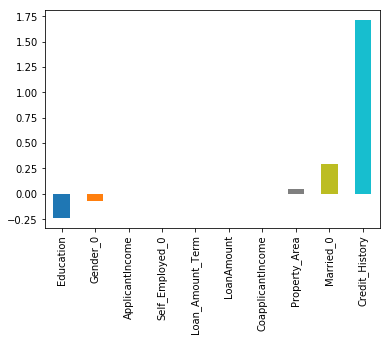

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

log_reg=LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(data_transformed_xtrain,y_train)


print('accuracy')
print('Train Accuracy: ',accuracy_score(log_reg.predict(data_transformed_xtrain),y_train))
print('Test Accuracy: ',accuracy_score(log_reg.predict(data_transformed_xtest),y_test))
print('')

print('roc_auc using second value')
print('Train Accuracy: ',roc_auc_score(y_train,log_reg.predict_proba(data_transformed_xtrain)[:,1]))
print('Test Accuracy: ',roc_auc_score(y_test,log_reg.predict_proba(data_transformed_xtest)[:,1]))
print('')

print('log loss')
print('Train Accuracy: ',log_loss(y_train,log_reg.predict_proba(data_transformed_xtrain)[:,1]))
print('Test Accuracy: ',log_loss(y_test,log_reg.predict_proba(data_transformed_xtest)[:,1]))
print('')

scoring = 'accuracy'
print('accuracy')
print('Cross validation train scores: ',model_selection.cross_val_score(log_reg, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(log_reg, data_transformed_xtest, y_test, cv=3, scoring=scoring))
#print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
print('')

scoring = 'log_loss'
print('log_loss')
print('Cross validation train scores: ',model_selection.cross_val_score(log_reg, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(log_reg, data_transformed_xtest, y_test, cv=3, scoring=scoring))
print('')

print('confusion metrics')
print(confusion_matrix(y_train, log_reg.predict(data_transformed_xtrain)))
print(confusion_matrix(y_test, log_reg.predict(data_transformed_xtest)))
print('')

print('classification report')
print(classification_report(y_train, log_reg.predict(data_transformed_xtrain)))
print(classification_report(y_test, log_reg.predict(data_transformed_xtest)))
print('')


## Feature Importance
print(log_reg.coef_[0])

import matplotlib.pyplot as plt
predictors = data_transformed_xtrain.columns
coef=Series(log_reg.coef_[0],predictors).sort_values()
coef.plot(kind='bar')


print(log_reg.predict_proba(data_transformed_xtest))

#### Grid Search CV - Decision Trees

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

parameters1={'max_depth':[2,3,4,6,8,10],'max_features':[2,4,6,8],'min_samples_leaf':[0.1,0.2,0.3],'min_samples_split':[0.1,0.2,0.3]}
dtc=DecisionTreeClassifier()

scoring=['precision']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    DTC_gridsearchcv=GridSearchCV(dtc,parameters1,cv=3,scoring='%s_macro' % score)
    DTC_gridsearchcv.fit(data_transformed_xtrain,y_train)
    print('Best Parameters:',DTC_gridsearchcv.best_params_)
    print('CV Results Keys: \n',DTC_gridsearchcv.cv_results_.keys())
    #print('CV Results: \n',DTC_gridsearchcv.cv_results_)
    #print('CV Results values: \n',DTC_gridsearchcv.cv_results_.values())

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Best Parameters: {'max_depth': 2, 'max_features': 6, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prudi\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

In [ ]:
#### Fitting the Decision Tree

accuracy
Train Accuracy:  0.7
Test Accuracy:  0.6493506493506493

roc_auc using second value
Train Accuracy:  0.5903884238005221
Test Accuracy:  0.5056481481481482

accuracy
Cross validation train scores:  [0.83766234 0.79738562 0.81045752]
Cross validation train scores:  [0.76923077 0.64705882 0.70588235]

neg_log_loss
Cross validation train scores:  [-0.67857125 -0.5333521  -0.63359463]
Cross validation train scores:  [-0.72987927 -0.71569559 -0.53443128]

confusion metrics
[[  0 138]
 [  0 322]]
[[  0  54]
 [  0 100]]

classification report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       138
          1       0.70      1.00      0.82       322

avg / total       0.49      0.70      0.58       460

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        54
          1       0.65      1.00      0.79       100

avg / total       0.42      0.65      0.51       154


[0.         0.     

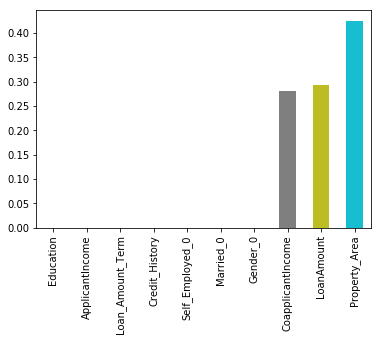

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

dtc=DecisionTreeClassifier(max_depth=2,max_features=4,min_samples_leaf=0.1,min_samples_split=0.2)
dtc.fit(data_transformed_xtrain,y_train)
print('accuracy')
print('Train Accuracy: ',accuracy_score(dtc.predict(data_transformed_xtrain),y_train))
print('Test Accuracy: ',accuracy_score(dtc.predict(data_transformed_xtest),y_test))
print('')
print('roc_auc using second value')
print('Train Accuracy: ',roc_auc_score(y_train,dtc.predict_proba(data_transformed_xtrain)[:,1]))
print('Test Accuracy: ',roc_auc_score(y_test,dtc.predict_proba(data_transformed_xtest)[:,1]))
print('')

scoring = 'accuracy'
print('accuracy')
print('Cross validation train scores: ',model_selection.cross_val_score(dtc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(dtc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
#print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
print('')
scoring = 'neg_log_loss'
print('neg_log_loss')
print('Cross validation train scores: ',model_selection.cross_val_score(dtc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(dtc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
print('')


print('confusion metrics')
print(confusion_matrix(y_train, dtc.predict(data_transformed_xtrain)))
print(confusion_matrix(y_test, dtc.predict(data_transformed_xtest)))
print('')

print('classification report')
print(classification_report(y_train, dtc.predict(data_transformed_xtrain)))
print(classification_report(y_test, dtc.predict(data_transformed_xtest)))
print('')


## Feature Importance
print(dtc.feature_importances_)

import matplotlib.pyplot as plt
predictors = data_transformed_xtrain.columns
coef=Series(dtc.feature_importances_,predictors).sort_values()
coef.plot(kind='bar')

print(dtc.predict_proba(data_transformed_xtest))

In [290]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())
graph

#### Grid Search CV - Random Forest

In [294]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

parameters1={'n_estimators':[3,5,7,9,11,13,15,21],'max_depth':[2,3,4,6,8,10],'max_features':[2,4,6,8],'min_samples_leaf':[0.1,0.2,0.3],'min_samples_split':[0.1,0.2,0.3]}
rfc=RandomForestClassifier()

scoring=['precision']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    rfc_gridsearchcv=GridSearchCV(rfc,parameters1,cv=3,scoring='%s_macro' % score)
    rfc_gridsearchcv.fit(data_transformed_xtrain,y_train)
    print('Best Parameters:',rfc_gridsearchcv.best_params_)
    print('CV Results Keys: \n',rfc_gridsearchcv.cv_results_.keys())
    #print('CV Results: \n',DTC_gridsearchcv.cv_results_)
    #print('CV Results values: \n',DTC_gridsearchcv.cv_results_.values())

Best Parameters: {'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 5}
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


accuracy
Train Accuracy:  0.7130434782608696
Test Accuracy:  0.6623376623376623

roc_auc using second value
Train Accuracy:  0.8093325231794041
Test Accuracy:  0.7180555555555556

accuracy
Cross validation train scores:  [0.7012987  0.7254902  0.69934641]
Cross validation train scores:  [0.76923077 0.56862745 0.62745098]

neg_log_loss
Cross validation train scores:  [-0.61184852 -0.55108223 -0.61124002]
Cross validation train scores:  [-0.70955472 -0.65955743 -0.59372984]

confusion metrics
[[  6 132]
 [  0 322]]
[[  2  52]
 [  0 100]]

classification report
             precision    recall  f1-score   support

          0       1.00      0.04      0.08       138
          1       0.71      1.00      0.83       322

avg / total       0.80      0.71      0.61       460

             precision    recall  f1-score   support

          0       1.00      0.04      0.07        54
          1       0.66      1.00      0.79       100

avg / total       0.78      0.66      0.54       154


[0.0

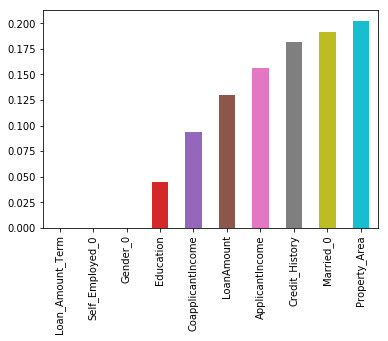

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

rfc=RandomForestClassifier(max_depth=8,max_features=8,min_samples_leaf=0.1,min_samples_split=0.1,n_estimators=5)
rfc.fit(data_transformed_xtrain,y_train)
print('accuracy')
print('Train Accuracy: ',accuracy_score(rfc.predict(data_transformed_xtrain),y_train))
print('Test Accuracy: ',accuracy_score(rfc.predict(data_transformed_xtest),y_test))
print('')
print('roc_auc using second value')
print('Train Accuracy: ',roc_auc_score(y_train,rfc.predict_proba(data_transformed_xtrain)[:,1]))
print('Test Accuracy: ',roc_auc_score(y_test,rfc.predict_proba(data_transformed_xtest)[:,1]))
print('')

scoring = 'accuracy'
print('accuracy')
print('Cross validation train scores: ',model_selection.cross_val_score(rfc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(rfc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
#print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
print('')
scoring = 'neg_log_loss'
print('neg_log_loss')
print('Cross validation train scores: ',model_selection.cross_val_score(rfc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(rfc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
print('')


print('confusion metrics')
print(confusion_matrix(y_train, rfc.predict(data_transformed_xtrain)))
print(confusion_matrix(y_test, rfc.predict(data_transformed_xtest)))
print('')

print('classification report')
print(classification_report(y_train, rfc.predict(data_transformed_xtrain)))
print(classification_report(y_test, rfc.predict(data_transformed_xtest)))
print('')


## Feature Importance
print(rfc.feature_importances_)

import matplotlib.pyplot as plt
predictors = data_transformed_xtrain.columns
coef=Series(rfc.feature_importances_,predictors).sort_values()
coef.plot(kind='bar')

In [19]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Grid Search CV - Gradient Boosting

In [300]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

parameters1={'n_estimators':[3,5,7,9,11,13,15,21],'max_depth':[2,3,4,6,8,10],'max_features':[2,4,6,8],'min_samples_leaf':[0.1,0.2,0.3],'min_samples_split':[0.1,0.2,0.3], 'learning_rate':[0.1,0.01],'loss':['deviance','exponential']}
rfc=GradientBoostingClassifier()

scoring=['precision']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    rfc_gridsearchcv=GridSearchCV(rfc,parameters1,cv=3,scoring='%s_macro' % score)
    rfc_gridsearchcv.fit(data_transformed_xtrain,y_train)
    print('Best Parameters:',rfc_gridsearchcv.best_params_)
    print('CV Results Keys: \n',rfc_gridsearchcv.cv_results_.keys())
    #print('CV Results: \n',DTC_gridsearchcv.cv_results_)
    #print('CV Results values: \n',DTC_gridsearchcv.cv_results_.values())

Best Parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 0.1, 'min_samples_split': 0.3, 'n_estimators': 13}
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_loss', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


accuracy
Train Accuracy:  0.8065217391304348
Test Accuracy:  0.7597402597402597

roc_auc using second value
Train Accuracy:  0.8205284003960753
Test Accuracy:  0.7106481481481481

accuracy
Cross validation train scores:  [0.7012987  0.81699346 0.69934641]
Cross validation train scores:  [0.67307692 0.7254902  0.64705882]

neg_log_loss
Cross validation train scores:  [-0.52170155 -0.50465045 -0.53376836]
Cross validation train scores:  [-0.57828465 -0.65561954 -0.55569859]

confusion metrics
[[ 53  85]
 [  4 318]]
[[18 36]
 [ 1 99]]

classification report
             precision    recall  f1-score   support

          0       0.93      0.38      0.54       138
          1       0.79      0.99      0.88       322

avg / total       0.83      0.81      0.78       460

             precision    recall  f1-score   support

          0       0.95      0.33      0.49        54
          1       0.73      0.99      0.84       100

avg / total       0.81      0.76      0.72       154


[0.10011

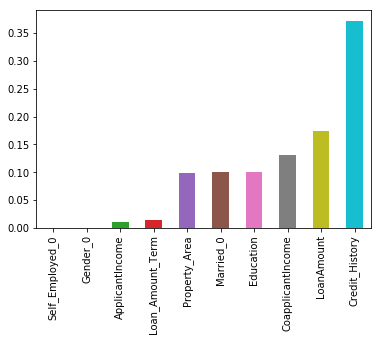

In [301]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

gbc=GradientBoostingClassifier(max_depth=2,max_features=2,min_samples_leaf=0.1,min_samples_split=0.3,n_estimators=13,learning_rate=0.1,loss='deviance')
gbc.fit(data_transformed_xtrain,y_train)
print('accuracy')
print('Train Accuracy: ',accuracy_score(gbc.predict(data_transformed_xtrain),y_train))
print('Test Accuracy: ',accuracy_score(gbc.predict(data_transformed_xtest),y_test))
print('')
print('roc_auc using second value')
print('Train Accuracy: ',roc_auc_score(y_train,gbc.predict_proba(data_transformed_xtrain)[:,1]))
print('Test Accuracy: ',roc_auc_score(y_test,gbc.predict_proba(data_transformed_xtest)[:,1]))
print('')

scoring = 'accuracy'
print('accuracy')
print('Cross validation train scores: ',model_selection.cross_val_score(gbc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(gbc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
#print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
print('')
scoring = 'neg_log_loss'
print('neg_log_loss')
print('Cross validation train scores: ',model_selection.cross_val_score(gbc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(gbc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
print('')


print('confusion metrics')
print(confusion_matrix(y_train, gbc.predict(data_transformed_xtrain)))
print(confusion_matrix(y_test, gbc.predict(data_transformed_xtest)))
print('')

print('classification report')
print(classification_report(y_train, gbc.predict(data_transformed_xtrain)))
print(classification_report(y_test, gbc.predict(data_transformed_xtest)))
print('')


## Feature Importance
print(gbc.feature_importances_)

import matplotlib.pyplot as plt
predictors = data_transformed_xtrain.columns
coef=Series(gbc.feature_importances_,predictors).sort_values()
coef.plot(kind='bar')

#### Grid Search CV - XGBoosting

In [308]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

parameters1={'n_estimators':[3,5,7,9,11,13,15,21],'max_depth':[2,3,4,6,8,10],'colsample_bytree':[0.7,0.8],'learning_rate':[0.1,0.01]}
xgbc=XGBClassifier()

scoring=['precision']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    xgbc_gridsearchcv=GridSearchCV(xgbc,parameters1,cv=3,scoring='%s_macro' % score)
    xgbc_gridsearchcv.fit(data_transformed_xtrain,y_train)
    print('Best Parameters:',xgbc_gridsearchcv.best_params_)
    print('CV Results Keys: \n',xgbc_gridsearchcv.cv_results_.keys())
    #print('CV Results: \n',xgbc_gridsearchcv.cv_results_)
    #print('CV Results values: \n',xgbc_gridsearchcv.cv_results_.values())

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_colsample_bytree', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


#### Fitting the XGBoosting

accuracy
Train Accuracy:  0.8326086956521739
Test Accuracy:  0.7532467532467533

roc_auc using second value
Train Accuracy:  0.8195719686740481
Test Accuracy:  0.7041666666666667

accuracy
Cross validation train scores:  [0.84415584 0.81699346 0.81045752]
Cross validation train scores:  [0.63461538 0.68627451 0.76470588]

neg_log_loss
Cross validation train scores:  [-0.67796507 -0.67829021 -0.67811457]
Cross validation train scores:  [-0.6829416  -0.68192636 -0.68142464]

confusion metrics
[[ 68  70]
 [  7 315]]
[[22 32]
 [ 6 94]]

classification report
             precision    recall  f1-score   support

          0       0.91      0.49      0.64       138
          1       0.82      0.98      0.89       322

avg / total       0.84      0.83      0.82       460

             precision    recall  f1-score   support

          0       0.79      0.41      0.54        54
          1       0.75      0.94      0.83       100

avg / total       0.76      0.75      0.73       154


[0.     

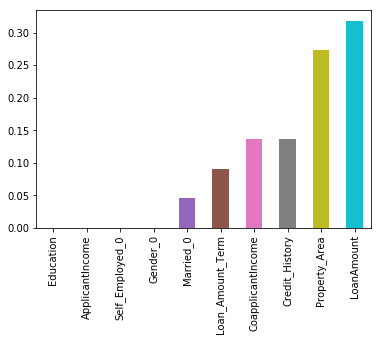

In [310]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

xgbc=XGBClassifier(colsample_bytree=0.8,learning_rate=0.01,max_depth=3,n_estimators=5)
xgbc.fit(data_transformed_xtrain,y_train)
print('accuracy')
print('Train Accuracy: ',accuracy_score(xgbc.predict(data_transformed_xtrain),y_train))
print('Test Accuracy: ',accuracy_score(xgbc.predict(data_transformed_xtest),y_test))
print('')
print('roc_auc using second value')
print('Train Accuracy: ',roc_auc_score(y_train,xgbc.predict_proba(data_transformed_xtrain)[:,1]))
print('Test Accuracy: ',roc_auc_score(y_test,xgbc.predict_proba(data_transformed_xtest)[:,1]))
print('')

scoring = 'accuracy'
print('accuracy')
print('Cross validation train scores: ',model_selection.cross_val_score(xgbc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(xgbc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
#print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
print('')
scoring = 'neg_log_loss'
print('neg_log_loss')
print('Cross validation train scores: ',model_selection.cross_val_score(xgbc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(xgbc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
print('')


print('confusion metrics')
print(confusion_matrix(y_train, xgbc.predict(data_transformed_xtrain)))
print(confusion_matrix(y_test, xgbc.predict(data_transformed_xtest)))
print('')

print('classification report')
print(classification_report(y_train, xgbc.predict(data_transformed_xtrain)))
print(classification_report(y_test, xgbc.predict(data_transformed_xtest)))
print('')


## Feature Importance
print(xgbc.feature_importances_)

import matplotlib.pyplot as plt
predictors = data_transformed_xtrain.columns
coef=Series(xgbc.feature_importances_,predictors).sort_values()
coef.plot(kind='bar')

#### Grid Search CV -KNN

In [314]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

parameters1={'n_neighbors':[3,5,7,9,11,13,15,21,31,41,51]}
knnc=KNeighborsClassifier()

scoring=['precision']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    knnc_gridsearchcv=GridSearchCV(knnc,parameters1,cv=3,scoring='%s_macro' % score)
    knnc_gridsearchcv.fit(data_transformed_xtrain,y_train)
    print('Best Parameters:',knnc_gridsearchcv.best_params_)
    print('CV Results Keys: \n',knnc_gridsearchcv.cv_results_.keys())
    #print('CV Results: \n',knnc_gridsearchcv.cv_results_)
    #print('CV Results values: \n',knnc_gridsearchcv.cv_results_.values())

Best Parameters: {'n_neighbors': 21}
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


In [ ]:
#### Fitting the KNN Model

In [315]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

knnc=KNeighborsClassifier(n_neighbors=21)
knnc.fit(data_transformed_xtrain,y_train)
print('accuracy')
print('Train Accuracy: ',accuracy_score(knnc.predict(data_transformed_xtrain),y_train))
print('Test Accuracy: ',accuracy_score(knnc.predict(data_transformed_xtest),y_test))
print('')
print('roc_auc using second value')
print('Train Accuracy: ',roc_auc_score(y_train,knnc.predict_proba(data_transformed_xtrain)[:,1]))
print('Test Accuracy: ',roc_auc_score(y_test,knnc.predict_proba(data_transformed_xtest)[:,1]))
print('')

scoring = 'accuracy'
print('accuracy')
print('Cross validation train scores: ',model_selection.cross_val_score(knnc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(knnc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
#print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
print('')
scoring = 'neg_log_loss'
print('neg_log_loss')
print('Cross validation train scores: ',model_selection.cross_val_score(knnc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(knnc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
print('')


print('confusion metrics')
print(confusion_matrix(y_train, knnc.predict(data_transformed_xtrain)))
print(confusion_matrix(y_test, knnc.predict(data_transformed_xtest)))
print('')

print('classification report')
print(classification_report(y_train, knnc.predict(data_transformed_xtrain)))
print(classification_report(y_test, knnc.predict(data_transformed_xtest)))
print('')


## Feature Importance


accuracy
Train Accuracy:  0.7
Test Accuracy:  0.6363636363636364

roc_auc using second value
Train Accuracy:  0.6277905302007382
Test Accuracy:  0.5237037037037037

accuracy
Cross validation train scores:  [0.7012987  0.70588235 0.70588235]
Cross validation train scores:  [0.63461538 0.62745098 0.64705882]

neg_log_loss
Cross validation train scores:  [-0.66766598 -0.66613651 -0.6542441 ]
Cross validation train scores:  [-0.72777264 -0.63168053 -0.66892011]

confusion metrics
[[  1 137]
 [  1 321]]
[[ 0 54]
 [ 2 98]]

classification report
             precision    recall  f1-score   support

          0       0.50      0.01      0.01       138
          1       0.70      1.00      0.82       322

avg / total       0.64      0.70      0.58       460

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        54
          1       0.64      0.98      0.78       100

avg / total       0.42      0.64      0.51       154




In [336]:
a=knnc.kneighbors()
len(a[0][0]), len(a[1][0])
len(a[0])
a

(array([[ 22.69362059,  29.8161111 ,  43.8748251 , ...,  99.87493818,
         102.77645802, 108.79338253],
        [ 12.08304879,  17.05872372,  18.52026302, ..., 125.2162395 ,
         127.29100578, 138.08620989],
        [ 30.69202308,  38.48378884,  51.02942428, ..., 144.22899401,
         181.37988221, 181.73332627],
        ...,
        [  5.19619985,  14.03567355,  14.0712789 , ...,  41.01219361,
          41.0121949 ,  44.01136218],
        [ 47.25029239,  57.80750723,  60.03337079, ..., 105.87761549,
         111.57593843, 115.44993672],
        [  1.00360155,   1.00464412,   1.42153547, ...,  11.43972267,
          12.25982542,  12.46222243]]),
 array([[190,  16, 174, ..., 273, 115, 320],
        [ 26, 332,  83, ..., 129,  62, 278],
        [435, 197, 242, ..., 177, 458, 131],
        ...,
        [314, 453,  40, ...,  92, 411,  73],
        [131, 175, 232, ..., 261, 303, 127],
        [322,  12, 101, ..., 449, 199,   5]], dtype=int64))

In [344]:
#### Leave on Out

(460, 10)

In [345]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()
loo.get_n_splits(data_transformed_xtrain)

for train_index, test_index in loo.split(data_transformed_xtrain):
    a=train_index


In [ ]:
#### Grid Search CV - Naive Bayes

In [351]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

parameters1={'alpha':[0.0001,0.0001,0.001,0.01,0.1,1,0.01]}
nbc=BernoulliNB()

scoring=['precision']
#scoring = {'AUC': 'roc_auc'}
for score in scoring:
    nbc_gridsearchcv=GridSearchCV(nbc,parameters1,cv=3,scoring='%s_macro' % score)
    nbc_gridsearchcv.fit(data_transformed_xtrain,y_train)
    print('Best Parameters:',nbc_gridsearchcv.best_params_)
    print('CV Results Keys: \n',nbc_gridsearchcv.cv_results_.keys())
    #print('CV Results: \n',nbc_gridsearchcv.cv_results_)
    #print('CV Results values: \n',nbc_gridsearchcv.cv_results_.values())

Best Parameters: {'alpha': 0.0001}
CV Results Keys: 
 dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])


In [ ]:
#### Fitting the KNN Model

In [356]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import Series, DataFrame

nbc=BernoulliNB(alpha=0.0001)
nbc.fit(data_transformed_xtrain,y_train)
print('accuracy')
print('Train Accuracy: ',accuracy_score(nbc.predict(data_transformed_xtrain),y_train))
print('Test Accuracy: ',accuracy_score(nbc.predict(data_transformed_xtest),y_test))
print('')
print('roc_auc using second value')
print('Train Accuracy: ',roc_auc_score(y_train,nbc.predict_proba(data_transformed_xtrain)[:,1]))
print('Test Accuracy: ',roc_auc_score(y_test,nbc.predict_proba(data_transformed_xtest)[:,1]))
print('')

scoring = 'accuracy'
print('accuracy')
print('Cross validation train scores: ',model_selection.cross_val_score(nbc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(nbc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
#print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())
print('')
scoring = 'neg_log_loss'
print('neg_log_loss')
print('Cross validation train scores: ',model_selection.cross_val_score(nbc, data_transformed_xtrain, y_train, cv=3, scoring=scoring))
print('Cross validation train scores: ',model_selection.cross_val_score(nbc, data_transformed_xtest, y_test, cv=3, scoring=scoring))
print('')


print('confusion metrics')
print(confusion_matrix(y_train, nbc.predict(data_transformed_xtrain)))
print(confusion_matrix(y_test, nbc.predict(data_transformed_xtest)))
print('')

print('classification report')
print(classification_report(y_train, nbc.predict(data_transformed_xtrain)))
print(classification_report(y_test, nbc.predict(data_transformed_xtest)))
print('')


## Feature Importance
print(nbc.coef_)

accuracy
Train Accuracy:  0.8239130434782609
Test Accuracy:  0.7662337662337663

roc_auc using second value
Train Accuracy:  0.8008934197497525
Test Accuracy:  0.7140740740740742

accuracy
Cross validation train scores:  [0.83116883 0.81699346 0.81045752]
Cross validation train scores:  [0.76923077 0.7254902  0.74509804]

neg_log_loss
Cross validation train scores:  [-0.44544379 -0.46708966 -0.45980387]
Cross validation train scores:  [-0.52794403 -0.56315752 -0.55113889]

confusion metrics
[[ 62  76]
 [  5 317]]
[[21 33]
 [ 3 97]]

classification report
             precision    recall  f1-score   support

          0       0.93      0.45      0.60       138
          1       0.81      0.98      0.89       322

avg / total       0.84      0.82      0.80       460

             precision    recall  f1-score   support

          0       0.88      0.39      0.54        54
          1       0.75      0.97      0.84       100

avg / total       0.79      0.77      0.74       154


[[-1.584

In [357]:
## Feature Importance
print(nbc.coef_)

[[-1.58489591e+00 -3.10558861e-07 -5.54195801e-01 -3.10558861e-07
  -3.10558861e-07 -1.56500773e-02 -2.89754818e-01 -2.03688017e+00
  -4.17965420e-01 -2.10031376e-01]]


In [371]:
neg_class_prob_sorted = nbc.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nbc.feature_log_prob_[1, :].argsort()


print(np.take(data_transformed_xtrain.columns, neg_class_prob_sorted[:10]))
print(np.take(data_transformed_xtrain.columns, pos_class_prob_sorted[:10]))

Index(['Self_Employed_0', 'Education', 'CoapplicantIncome', 'Credit_History',
       'Married_0', 'Property_Area', 'Gender_0', 'ApplicantIncome',
       'LoanAmount', 'Loan_Amount_Term'],
      dtype='object')
Index(['Self_Employed_0', 'Education', 'CoapplicantIncome', 'Married_0',
       'Property_Area', 'Gender_0', 'Credit_History', 'ApplicantIncome',
       'LoanAmount', 'Loan_Amount_Term'],
      dtype='object')


In [372]:
nbc.class_log_prior_

array([-1.2039728 , -0.35667494])

In [377]:
nbc.intercept_

array([-0.35667494])

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_transformed_xtrain)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [ ]:
#### Finding the right k using elbow methond - Kmeans

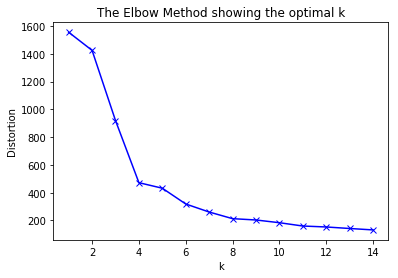

In [51]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1,15)
distortions=[]
for i in K:
    kmeanModel = KMeans(n_clusters=i, random_state=0)
    kmeanModel.fit(data_transformed_xtrain)
    distortions.append(sum(np.min(cdist(data_transformed_xtrain, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_transformed_xtrain.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


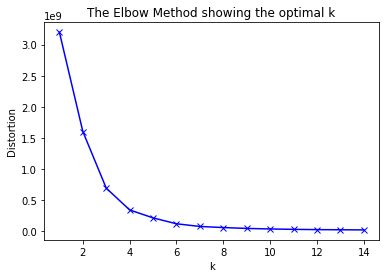

In [50]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed_xtrain)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
#### Fitting the kmeans

In [52]:
km = KMeans(n_clusters=6)
km.fit(data_transformed_xtrain)
km.predict(data_transformed_xtrain)

array([5, 5, 1, 1, 5, 1, 1, 0, 5, 1, 5, 5, 1, 5, 4, 0, 5, 0, 1, 5, 1, 5,
       0, 1, 1, 1, 5, 1, 1, 5, 1, 5, 0, 5, 5, 1, 0, 0, 1, 5, 1, 1, 5, 0,
       5, 5, 1, 1, 5, 0, 5, 1, 1, 1, 1, 1, 1, 5, 3, 5, 1, 0, 5, 1, 5, 5,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 5, 0, 5, 0, 1, 5, 1, 4, 5, 1, 0, 1, 1,
       5, 1, 0, 5, 1, 5, 5, 1, 1, 5, 0, 1, 5, 1, 0, 1, 1, 1, 1, 1, 4, 5,
       1, 0, 1, 1, 1, 5, 1, 1, 5, 1, 0, 1, 4, 1, 1, 1, 0, 1, 1, 5, 1, 1,
       0, 0, 4, 5, 1, 5, 5, 4, 5, 1, 5, 1, 1, 5, 1, 5, 1, 1, 1, 5, 0, 4,
       1, 5, 0, 1, 4, 1, 1, 1, 5, 5, 1, 1, 1, 1, 4, 1, 1, 0, 1, 5, 5, 1,
       1, 1, 5, 0, 5, 5, 1, 5, 5, 5, 1, 5, 5, 4, 5, 1, 0, 5, 1, 1, 1, 1,
       5, 1, 1, 5, 4, 1, 4, 5, 5, 0, 1, 1, 1, 1, 1, 5, 1, 0, 0, 1, 1, 5,
       5, 5, 1, 0, 5, 1, 1, 1, 1, 1, 4, 1, 1, 0, 1, 1, 1, 5, 1, 1, 3, 1,
       1, 1, 5, 5, 1, 5, 5, 5, 1, 1, 1, 1, 0, 1, 5, 1, 0, 5, 5, 1, 0, 5,
       1, 0, 1, 5, 5, 0, 1, 1, 5, 5, 1, 5, 1, 1, 5, 5, 5, 5, 1, 5, 0, 0,
       1, 1, 2, 1, 5, 5, 1, 5, 0, 1, 5, 1, 5, 1, 1,

In [ ]:
#### Principle Component Analysis


Explained variance [1.34176596e+07 6.36947631e+03 2.60330387e+03 6.28547253e-01
 2.38372048e-01 1.72318452e-01 1.18221871e-01 1.06776221e-01
 8.82584378e-02 4.12891753e-03]

Percentage varinace explained [9.99331617e-01 4.74391156e-04 1.93891031e-04 4.68134653e-08
 1.77536717e-08 1.28340770e-08 8.80502690e-09 7.95256819e-09
 6.57338536e-09 3.07516955e-10]

cummulative variace explained [ 99.93316168  99.98060079  99.9999899   99.99999458  99.99999635
  99.99999764  99.99999852  99.99999931  99.99999997 100.        ]

[4.53089607e+04 9.87182797e+02 6.31114484e+02 9.80651466e+00
 6.03911611e+00 5.13465901e+00 4.25299263e+00 4.04187602e+00
 3.67471645e+00 7.94810909e-01]


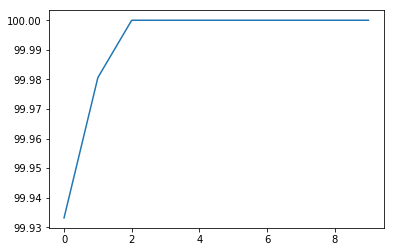

In [36]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(data_transformed_xtest)
pca_data=pca.transform(data_transformed_xtrain)
print('')
print('Explained variance',pca.explained_variance_)
print('')
percentage_var_explained=pca.explained_variance_/np.sum(pca.explained_variance_)
print('Percentage varinace explained',percentage_var_explained)
print('')
cum_var_explained=np.cumsum(percentage_var_explained)*100
print('cummulative variace explained',cum_var_explained)
print('')

print(pca.singular_values_)

#print(pca.inverse_transform(pca_data))
plt.plot(cum_var_explained)

In [ ]:
#### Hyperprameter tuning

In [42]:
from sklearn.manifold import TSNE
tsne=TSNE()
tsne.fit(data_transformed_xtrain)
tsne.pr

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)